In [75]:
import os
import time
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets, models

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.manifold import TSNE
from umap import UMAP

In [76]:
DATA_DIR = Path("dataset/paintings")
IMG_SIZE = 288
RESIZE_SIZE = 320
BATCH_SIZE = 64

EPOCHS = 20
LR_CNN = 3e-4
TRAIN_SIZE = 0.7
TEST_SIZE = 0.15
VAL_SIZE = 0.15

EPOCHS_TL_FROZEN = 5
EPOCHS_TL_FINETUNE = 10
LR_TL = 1e-3
LR_TL_FINETUNE = 3e-4

SAMPLE_SIZE = 1200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
class PaintingsDataset(Dataset):
    def __init__(self, samples, classes, transform=None):
        self.samples = samples
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, y = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, y


In [78]:
def stratified_split_indices(targets, train=TRAIN_SIZE, val=VAL_SIZE, test=TEST_SIZE, seed=42):
    by_class = defaultdict(list)
    for i, y in enumerate(targets):
        by_class[y].append(i)

    rng = random.Random(seed)
    train_idx, val_idx, test_idx = [], [], []
    for y, idxs in by_class.items():
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(n * train)
        n_val = int(n * val)
        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])
    return train_idx, val_idx, test_idx

def build_datasets_and_loaders(root_dir):
    base_ds = datasets.ImageFolder(root=root_dir.as_posix(), transform=None)
    classes = base_ds.classes
    targets = [y for _, y in base_ds.samples]

    train_idx, val_idx, test_idx = stratified_split_indices(targets)

    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        # mean и стандартное отклонение датасета ImageNet, 
        # на которых обучалась модель ResNet18, 
        # а для CNN эти значения тоже можно заиспользовать, чтобы эффективнее срвнивать модели
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    test_tf = transforms.Compose([
        transforms.Resize(RESIZE_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    samples = base_ds.samples
    train_samples = [samples[i] for i in train_idx]
    val_samples = [samples[i] for i in val_idx]
    test_samples = [samples[i] for i in test_idx]

    train_ds = PaintingsDataset(train_samples, classes, transform=train_tf)
    val_ds = PaintingsDataset(val_samples, classes, transform=test_tf)
    test_ds = PaintingsDataset(test_samples, classes, transform=test_tf)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, classes

In [79]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), 
            nn.BatchNorm2d(32), 
            nn.SiLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.BatchNorm2d(64), 
            nn.SiLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), 
            nn.BatchNorm2d(128), 
            nn.SiLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, padding=1), 
            nn.BatchNorm2d(256), 
            nn.SiLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.emb_dim = 256
        self.fc = nn.Linear(self.emb_dim, num_classes)

    def forward(self, x, return_features=False):
        x = self.features(x)
        feats = x.flatten(1)
        logits = self.fc(feats)
        if return_features:
            return logits, feats
        return logits

In [80]:
def evaluate(model, loader, device):
    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            all_logits.append(logits.cpu())
            all_y.append(y)

    logits = torch.cat(all_logits, dim=0)
    y_true = torch.cat(all_y, dim=0)
    y_pred = logits.argmax(1)

    y_true_np = y_true.numpy()
    y_pred_np = y_pred.numpy()

    acc = accuracy_score(y_true_np, y_pred_np)
    f1m = f1_score(y_true_np, y_pred_np, average="macro")
    
    return acc, f1m, y_true_np, y_pred_np


def _evaluate_epoch(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)

            running_loss += loss.item()
            pred = out.argmax(1)
            total += y.size(0)
            correct += (pred == y).sum().item()

    avg_loss = running_loss / len(loader)
    acc = 100.0 * correct / total
    return avg_loss, acc

In [81]:
class TLResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        res = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*(list(res.children())[:-1]))
        self.feat_dim = 512
        self.fc1 = nn.Linear(self.feat_dim, 256)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x, return_embedding=False):
        f = self.backbone(x)
        f = torch.flatten(f, 1)
        z_lin = self.fc1(f)
        z = self.relu(z_lin)
        z = self.drop(z)
        logits = self.fc2(z)
        if return_embedding:
            return logits, z_lin
        return logits

    def get_embedding(self, x):
        _logits, z_lin = self.forward(x, return_embedding=True)
        return z_lin

In [95]:
def plot_2d(X_2d, Y, classes, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    unique = np.unique(Y)
    cmap = plt.get_cmap("Paired")
    colors = cmap(np.linspace(0, 1, max(10, len(unique))))
    
    for i, c in enumerate(unique):
        idx = (Y == c)
        label = classes[c] if classes is not None and 0 <= int(c) < len(classes) else str(c)
        ax.scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            s=60,
            alpha=0.75,
            color=colors[i],
            label=label
        )

    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Classes", fontsize=9, markerscale=1)
    fig.tight_layout()
    plt.show()

In [83]:
train_loader, val_loader, test_loader, classes = build_datasets_and_loaders(DATA_DIR)
print(classes)

['baroque', 'medieval', 'modern']


In [ ]:
def train_model_cnn(model, train_loader, val_loader, test_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_CNN, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS // 3, gamma=0.5)

    writer = SummaryWriter(log_dir=f"runs/s_cnn_{int(time.time())}")
    best_val_acc = 0.0
    best_state = None

    print(f"Start training CNN model")

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        pbar = tqdm(
            enumerate(train_loader),
            total=len(train_loader),
            desc=f"CNN Epoch {epoch}/{EPOCHS}",
        )

        for batch_idx, (inputs, labels) in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            out = model(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = out.argmax(1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

            avg_loss = running_loss / (batch_idx + 1)
            acc = 100.0 * correct / total
            pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.2f}%")

        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_acc = 100.0 * correct / total

        val_loss, val_acc = _evaluate_epoch(model, val_loader, device, criterion)

        writer.add_scalar("cnn/train_loss", train_epoch_loss, epoch) # по условию требовали сохранять в tensorboard, но мне удобнее через print следить
        writer.add_scalar("cnn/train_acc", train_epoch_acc, epoch)
        writer.add_scalar("cnn/val_loss", val_loss, epoch)
        writer.add_scalar("cnn/val_acc", val_acc, epoch)

        print(f"[CNN] Epoch {epoch}/{EPOCHS} | Train: loss={train_epoch_loss:.4f} acc={train_epoch_acc:.2f}% | Val: loss={val_loss:.4f} acc={val_acc:.2f}%")

        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

            Path("models").mkdir(exist_ok=True)
            torch.save(best_state, "models/cnn_best.pth")
            print("The best CNN model has been saved")

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            all_logits.append(out.cpu())
            all_y.append(y)

    logits = torch.cat(all_logits)
    y_true = torch.cat(all_y).numpy()
    y_pred = logits.argmax(1).numpy()

    test_acc = accuracy_score(y_true, y_pred) * 100.0
    test_f1 = f1_score(y_true, y_pred, average="macro")

    print(f"[CNN] Test acc={test_acc:.2f}% f1_macro={test_f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=classes))

    writer.close()

    return model, {
        "val_best_acc": best_val_acc / 100.0,
        "test_acc": test_acc / 100.0,
        "test_f1": test_f1,
    }

In [85]:
cnn_model = SimpleCNN(len(classes)).to(device)
cnn_model, cnn_stats = train_model_cnn(cnn_model, train_loader, val_loader, test_loader)

Start training CNN model


CNN Epoch 1/20: 100%|██████████| 38/38 [03:38<00:00,  5.74s/it, acc=65.57%, loss=0.7931]


[CNN] Epoch 1/20 | Train: loss=0.7931 acc=65.57% | Val: loss=0.8114 acc=62.80%
The best CNN model has been saved


CNN Epoch 2/20: 100%|██████████| 38/38 [03:13<00:00,  5.10s/it, acc=71.47%, loss=0.7169]


[CNN] Epoch 2/20 | Train: loss=0.7169 acc=71.47% | Val: loss=0.6710 acc=71.85%
The best CNN model has been saved


CNN Epoch 3/20: 100%|██████████| 38/38 [02:55<00:00,  4.63s/it, acc=73.16%, loss=0.6946]


[CNN] Epoch 3/20 | Train: loss=0.6946 acc=73.16% | Val: loss=0.6287 acc=74.61%
The best CNN model has been saved


CNN Epoch 4/20: 100%|██████████| 38/38 [02:59<00:00,  4.73s/it, acc=73.49%, loss=0.6610]


[CNN] Epoch 4/20 | Train: loss=0.6610 acc=73.49% | Val: loss=0.6718 acc=70.08%


CNN Epoch 5/20: 100%|██████████| 38/38 [02:59<00:00,  4.72s/it, acc=73.58%, loss=0.6644]


[CNN] Epoch 5/20 | Train: loss=0.6644 acc=73.58% | Val: loss=0.5982 acc=75.00%
The best CNN model has been saved


CNN Epoch 6/20: 100%|██████████| 38/38 [03:04<00:00,  4.85s/it, acc=75.68%, loss=0.6140]


[CNN] Epoch 6/20 | Train: loss=0.6140 acc=75.68% | Val: loss=0.6180 acc=74.41%


CNN Epoch 7/20: 100%|██████████| 38/38 [03:27<00:00,  5.47s/it, acc=77.03%, loss=0.6012]


[CNN] Epoch 7/20 | Train: loss=0.6012 acc=77.03% | Val: loss=0.5522 acc=77.56%
The best CNN model has been saved


CNN Epoch 8/20: 100%|██████████| 38/38 [03:20<00:00,  5.27s/it, acc=76.40%, loss=0.6269]


[CNN] Epoch 8/20 | Train: loss=0.6269 acc=76.40% | Val: loss=0.5628 acc=78.74%
The best CNN model has been saved


CNN Epoch 9/20: 100%|██████████| 38/38 [03:18<00:00,  5.23s/it, acc=77.08%, loss=0.5799]


[CNN] Epoch 9/20 | Train: loss=0.5799 acc=77.08% | Val: loss=0.5969 acc=75.59%


CNN Epoch 10/20: 100%|██████████| 38/38 [02:51<00:00,  4.50s/it, acc=78.63%, loss=0.5533]


[CNN] Epoch 10/20 | Train: loss=0.5533 acc=78.63% | Val: loss=0.5181 acc=79.33%
The best CNN model has been saved


CNN Epoch 11/20: 100%|██████████| 38/38 [02:49<00:00,  4.46s/it, acc=77.29%, loss=0.5530]


[CNN] Epoch 11/20 | Train: loss=0.5530 acc=77.29% | Val: loss=0.5095 acc=82.28%
The best CNN model has been saved


CNN Epoch 12/20: 100%|██████████| 38/38 [02:52<00:00,  4.55s/it, acc=79.14%, loss=0.5595]


[CNN] Epoch 12/20 | Train: loss=0.5595 acc=79.14% | Val: loss=0.5161 acc=79.72%


CNN Epoch 13/20: 100%|██████████| 38/38 [02:54<00:00,  4.58s/it, acc=79.69%, loss=0.5157]


[CNN] Epoch 13/20 | Train: loss=0.5157 acc=79.69% | Val: loss=0.4879 acc=79.92%


CNN Epoch 14/20: 100%|██████████| 38/38 [03:17<00:00,  5.19s/it, acc=80.53%, loss=0.5178]


[CNN] Epoch 14/20 | Train: loss=0.5178 acc=80.53% | Val: loss=0.4802 acc=80.71%


CNN Epoch 15/20: 100%|██████████| 38/38 [03:00<00:00,  4.76s/it, acc=79.94%, loss=0.5316]


[CNN] Epoch 15/20 | Train: loss=0.5316 acc=79.94% | Val: loss=0.5567 acc=79.53%


CNN Epoch 16/20: 100%|██████████| 38/38 [03:01<00:00,  4.78s/it, acc=78.85%, loss=0.5213]


[CNN] Epoch 16/20 | Train: loss=0.5213 acc=78.85% | Val: loss=0.4810 acc=81.69%


CNN Epoch 17/20: 100%|██████████| 38/38 [03:02<00:00,  4.81s/it, acc=80.28%, loss=0.5109]


[CNN] Epoch 17/20 | Train: loss=0.5109 acc=80.28% | Val: loss=0.4877 acc=80.31%


CNN Epoch 18/20: 100%|██████████| 38/38 [03:26<00:00,  5.42s/it, acc=81.25%, loss=0.5084]


[CNN] Epoch 18/20 | Train: loss=0.5084 acc=81.25% | Val: loss=0.5375 acc=78.15%


CNN Epoch 19/20: 100%|██████████| 38/38 [03:08<00:00,  4.97s/it, acc=82.43%, loss=0.4931]


[CNN] Epoch 19/20 | Train: loss=0.4931 acc=82.43% | Val: loss=0.4524 acc=83.46%
The best CNN model has been saved


CNN Epoch 20/20: 100%|██████████| 38/38 [03:03<00:00,  4.83s/it, acc=82.13%, loss=0.4699]


[CNN] Epoch 20/20 | Train: loss=0.4699 acc=82.13% | Val: loss=0.4504 acc=81.69%
[CNN] Test acc=84.71% f1_macro=0.8466
              precision    recall  f1-score   support

     baroque       0.82      0.86      0.84       180
    medieval       0.89      0.84      0.87       180
      modern       0.83      0.84      0.83       150

    accuracy                           0.85       510
   macro avg       0.85      0.85      0.85       510
weighted avg       0.85      0.85      0.85       510



In [86]:
def extract_embeddings_cnn(model, loader):
    model.eval()
    X, Y = [], []
    with torch.no_grad():
        count = 0
        for x, y in loader:
            x = x.to(device)
            logits, feats = model(x, return_features=True)
            X.append(feats.cpu())
            Y.append(y)
            count += x.size(0)
            if count >= SAMPLE_SIZE:
                break
    X = torch.cat(X, dim=0)[:SAMPLE_SIZE].numpy()
    Y = torch.cat(Y, dim=0)[:SAMPLE_SIZE].numpy()
    return X,Y

def visualize_embeddings_tsne_umap_cnn(model, subset_loader, classes):
    X, Y = extract_embeddings_cnn(model, subset_loader)
    n = len(X)
    perpl = max(5, min(30, n // 3))
    perpl = min(perpl, max(2, n - 1))
    
    tsne = TSNE(perplexity=perpl, metric="cosine")
    X_tsne = tsne.fit_transform(X)
    plot_2d(X_tsne, Y, classes, "t-SNE (CNN), metric: cosine")
    
    umap = UMAP(metric="cosine")
    X_umap = umap.fit_transform(X)
    plot_2d(X_umap, Y, classes, "UMAP (CNN), metric: cosine")


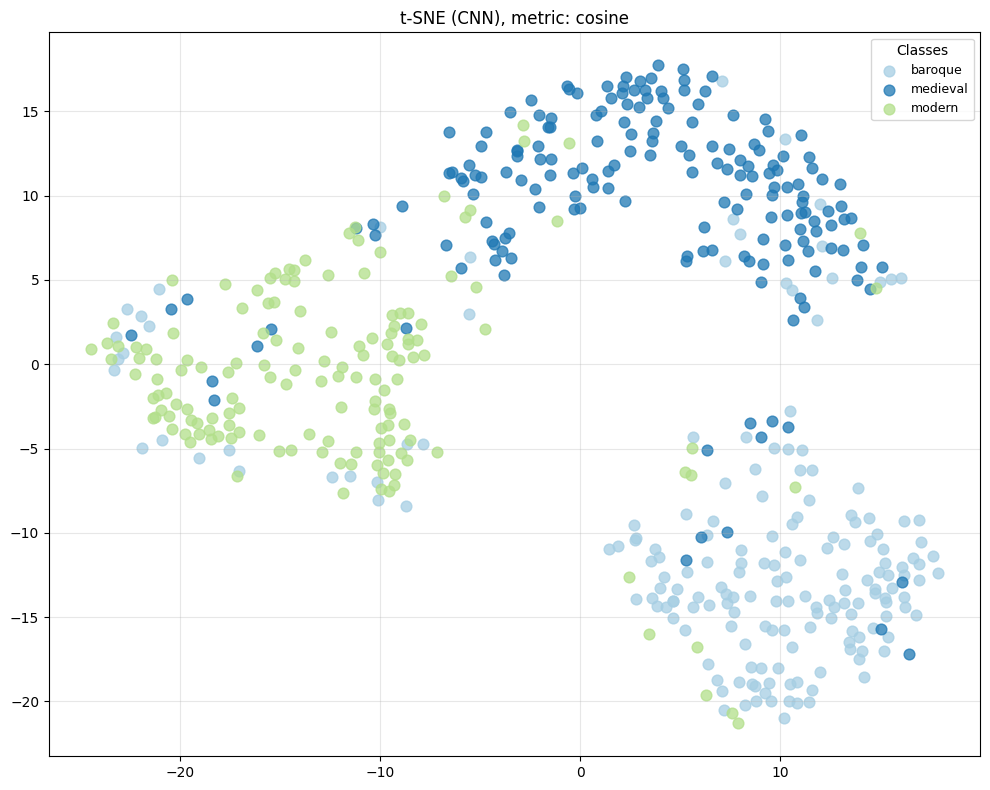

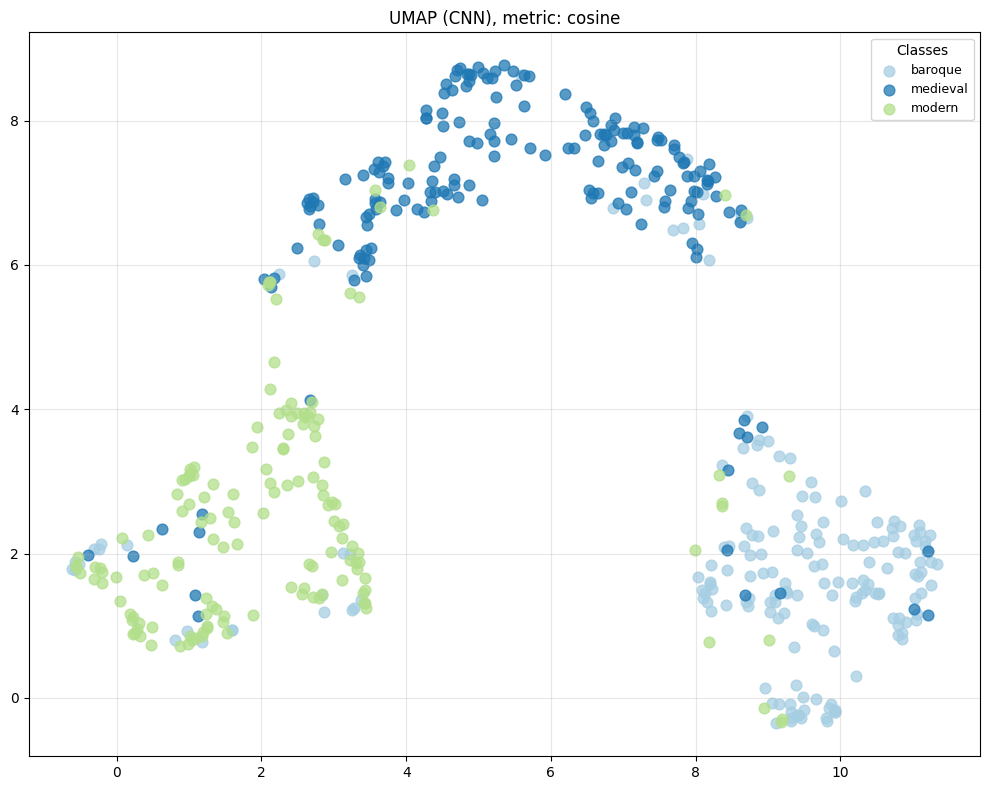

In [96]:
visualize_embeddings_tsne_umap_cnn(cnn_model, test_loader, classes)

In [110]:
def train_model_tl(model, train_loader, val_loader, test_loader, classes):
    criterion = nn.CrossEntropyLoss()
    writer = SummaryWriter(log_dir=f"runs/tl_resnet18_{int(time.time())}")

    os.makedirs("models", exist_ok=True)

    best_val_acc = 0.0
    best_state = None
    
    for p in model.backbone.parameters():
        p.requires_grad = False

    params = list(model.fc1.parameters()) + list(model.fc2.parameters())
    optimizer = torch.optim.Adam(params, lr=LR_TL, weight_decay=1e-4) 
    # на Adam гораздо эффективнее, чем на SGD (на первой эпохе с Adam loss ~ 0,6, с SGD ~ 0,9)
    # к 5-ой эпохе frozen-этапа на Adam добивает до 90% accuracy, на SGD максимум 77%
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    print("Start training ResNet18")

    for epoch in range(1, EPOCHS_TL_FROZEN + 1):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        pbar = tqdm(
            enumerate(train_loader),
            total=len(train_loader),
            desc=f"[TL frozen] Epoch {epoch}/{EPOCHS_TL_FROZEN}",
        )

        for batch_idx, (inputs, labels) in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            out = model(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = out.argmax(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

            avg_loss = running_loss / (batch_idx + 1)
            acc = 100.0 * correct / total
            pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.2f}%")

        scheduler.step()

        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_acc = 100.0 * correct / total
        val_loss, val_acc = _evaluate_epoch(model, val_loader, device, criterion)

        writer.add_scalar("tl_frozen/train_loss", train_epoch_loss, epoch)
        writer.add_scalar("tl_frozen/train_acc", train_epoch_acc, epoch)
        writer.add_scalar("tl_frozen/val_loss", val_loss, epoch)
        writer.add_scalar("tl_frozen/val_acc", val_acc, epoch)

        print(f"[TL frozen] Epoch {epoch}/{EPOCHS_TL_FROZEN} | Train: loss={train_epoch_loss:.4f} acc={train_epoch_acc:.2f}% | Val: loss={val_loss:.4f} acc={val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, "models/tl_resnet18_best.pth")
            print("The best ResNet18 model has been saved")
        

    for p in model.backbone.parameters():
        p.requires_grad = True

    optimizer = torch.optim.Adam(
        [
            {"params": model.backbone.parameters(), "lr": 0.5 * 3e-4},
            {"params": list(model.fc1.parameters()) + list(model.fc2.parameters()), "lr": LR_TL_FINETUNE},
        ],
        weight_decay=1e-4,
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_TL_FINETUNE, eta_min=1e-6)

    print("Start finetuning ResNet18")

    for epoch in range(1, EPOCHS_TL_FINETUNE + 1):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        pbar = tqdm(
            enumerate(train_loader),
            total=len(train_loader),
            desc=f"[TL finetune] Epoch {epoch}/{EPOCHS_TL_FINETUNE}",
        )

        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            out = model(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = out.argmax(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

            avg_loss = running_loss / (batch_idx + 1)
            acc = 100.0 * correct / total
            pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.2f}%")

        scheduler.step()

        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_acc = 100.0 * correct / total
        val_loss, val_acc = _evaluate_epoch(model, val_loader, device, criterion)

        writer.add_scalar("tl_finetune/train_loss", train_epoch_loss, epoch)
        writer.add_scalar("tl_finetune/train_acc", train_epoch_acc, epoch)
        writer.add_scalar("tl_finetune/val_loss", val_loss, epoch)
        writer.add_scalar("tl_finetune/val_acc", val_acc, epoch)

        print(f"[TL finetune] Epoch {epoch}/{EPOCHS_TL_FINETUNE} | Train: loss={train_epoch_loss:.4f} acc={train_epoch_acc:.2f}% | Val: loss={val_loss:.4f} acc={val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, "models/tl_resnet18_best.pth")
            print("The best Transfer Learning ResNet model has been saved")

    model.load_state_dict(best_state)

    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            out = model(inputs)
            all_logits.append(out)
            all_y.append(labels)

    logits = torch.cat(all_logits).cpu()
    y_true = torch.cat(all_y).cpu().numpy()
    y_pred = logits.argmax(1).numpy()

    test_acc = accuracy_score(y_true, y_pred) * 100.0
    test_f1 = f1_score(y_true, y_pred, average="macro")

    print(f"[TL] Test acc={test_acc:.2f}% f1_macro={test_f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=classes))

    writer.close()

    return model, {
        "val_best_acc": best_val_acc / 100.0,
        "test_acc": test_acc / 100.0,
        "test_f1": test_f1,
    }


In [111]:
tl_model = TLResNet18(len(classes)).to(device)
tl_model, tl_stats = train_model_tl(tl_model, train_loader, val_loader, test_loader, classes)

Start training ResNet18


[TL frozen] Epoch 1/5: 100%|██████████| 38/38 [01:38<00:00,  2.59s/it, acc=73.83%, loss=0.6314]


[TL frozen] Epoch 1/5 | Train: loss=0.6314 acc=73.83% | Val: loss=0.3997 acc=85.43%
The best ResNet18 model has been saved


[TL frozen] Epoch 2/5: 100%|██████████| 38/38 [02:09<00:00,  3.42s/it, acc=85.42%, loss=0.3898]


[TL frozen] Epoch 2/5 | Train: loss=0.3898 acc=85.42% | Val: loss=0.2524 acc=90.55%
The best ResNet18 model has been saved


[TL frozen] Epoch 3/5: 100%|██████████| 38/38 [02:01<00:00,  3.20s/it, acc=89.97%, loss=0.2708]


[TL frozen] Epoch 3/5 | Train: loss=0.2708 acc=89.97% | Val: loss=0.2351 acc=91.93%
The best ResNet18 model has been saved


[TL frozen] Epoch 4/5: 100%|██████████| 38/38 [02:04<00:00,  3.27s/it, acc=91.02%, loss=0.2837]


[TL frozen] Epoch 4/5 | Train: loss=0.2837 acc=91.02% | Val: loss=0.2258 acc=92.72%
The best ResNet18 model has been saved


[TL frozen] Epoch 5/5: 100%|██████████| 38/38 [02:24<00:00,  3.80s/it, acc=87.10%, loss=0.3357]


[TL frozen] Epoch 5/5 | Train: loss=0.3357 acc=87.10% | Val: loss=0.2093 acc=91.93%
Start finetuning ResNet18


[TL finetune] Epoch 1/10: 100%|██████████| 38/38 [05:15<00:00,  8.30s/it, acc=92.71%, loss=0.2251]


[TL finetune] Epoch 1/10 | Train: loss=0.2251 acc=92.71% | Val: loss=0.1531 acc=93.90%
The best Transfer Learning ResNet model has been saved


[TL finetune] Epoch 2/10: 100%|██████████| 38/38 [05:29<00:00,  8.67s/it, acc=97.18%, loss=0.0758]


[TL finetune] Epoch 2/10 | Train: loss=0.0758 acc=97.18% | Val: loss=0.1244 acc=95.47%
The best Transfer Learning ResNet model has been saved


[TL finetune] Epoch 3/10: 100%|██████████| 38/38 [05:25<00:00,  8.57s/it, acc=97.43%, loss=0.0727]


[TL finetune] Epoch 3/10 | Train: loss=0.0727 acc=97.43% | Val: loss=0.1470 acc=94.69%


[TL finetune] Epoch 4/10: 100%|██████████| 38/38 [05:44<00:00,  9.06s/it, acc=98.02%, loss=0.0692]


[TL finetune] Epoch 4/10 | Train: loss=0.0692 acc=98.02% | Val: loss=0.0624 acc=97.24%
The best Transfer Learning ResNet model has been saved


[TL finetune] Epoch 5/10: 100%|██████████| 38/38 [05:34<00:00,  8.81s/it, acc=97.98%, loss=0.0621]


[TL finetune] Epoch 5/10 | Train: loss=0.0621 acc=97.98% | Val: loss=0.1117 acc=96.65%


[TL finetune] Epoch 6/10: 100%|██████████| 38/38 [05:55<00:00,  9.34s/it, acc=98.78%, loss=0.0341]


[TL finetune] Epoch 6/10 | Train: loss=0.0341 acc=98.78% | Val: loss=0.0813 acc=97.05%


[TL finetune] Epoch 7/10: 100%|██████████| 38/38 [05:03<00:00,  7.98s/it, acc=99.45%, loss=0.0174]


[TL finetune] Epoch 7/10 | Train: loss=0.0174 acc=99.45% | Val: loss=0.0712 acc=97.64%
The best Transfer Learning ResNet model has been saved


[TL finetune] Epoch 8/10: 100%|██████████| 38/38 [05:40<00:00,  8.95s/it, acc=99.79%, loss=0.0073]


[TL finetune] Epoch 8/10 | Train: loss=0.0073 acc=99.79% | Val: loss=0.0713 acc=97.83%
The best Transfer Learning ResNet model has been saved


[TL finetune] Epoch 9/10: 100%|██████████| 38/38 [05:12<00:00,  8.21s/it, acc=99.75%, loss=0.0085] 


[TL finetune] Epoch 9/10 | Train: loss=0.0085 acc=99.75% | Val: loss=0.0840 acc=97.05%


[TL finetune] Epoch 10/10: 100%|██████████| 38/38 [05:46<00:00,  9.11s/it, acc=99.83%, loss=0.0078]


[TL finetune] Epoch 10/10 | Train: loss=0.0078 acc=99.83% | Val: loss=0.0796 acc=97.05%
[TL] Test acc=98.82% f1_macro=0.9881
              precision    recall  f1-score   support

     baroque       0.99      0.97      0.98       180
    medieval       0.99      0.99      0.99       180
      modern       0.97      1.00      0.99       150

    accuracy                           0.99       510
   macro avg       0.99      0.99      0.99       510
weighted avg       0.99      0.99      0.99       510



In [116]:
def extract_embeddings_tl(model, loader):
    model.eval()
    X, Y = [], []
    with torch.no_grad():
        count = 0
        for x, y in loader:
            x = x.to(device)
            z_lin = model.get_embedding(x)
            X.append(z_lin.cpu())
            Y.append(y)
            count += x.size(0)
            if count >= SAMPLE_SIZE:
                break
    X = torch.cat(X, dim=0)[:SAMPLE_SIZE].numpy()
    Y = torch.cat(Y, dim=0)[:SAMPLE_SIZE].numpy()
    return X, Y

def visualize_embeddings_tl(model, subset_loader, classes):
    X, Y = extract_embeddings_tl(model, subset_loader)
    n = len(X)
    perpl = min(30, max(5, n // 3))
    perpl = min(perpl, n - 1)

    tsne = TSNE(perplexity=perpl, metric="cosine")
    X_tsne = tsne.fit_transform(X)
    plot_2d(X_tsne, Y, classes, "t-SNE (Transfer Learning ResNet18), metric: cosine")

    umap = UMAP(metric="cosine")
    X_umap = umap.fit_transform(X)
    plot_2d(X_umap, Y, classes, "UMAP (Transfer Learning ResNet18), metric: cosine")

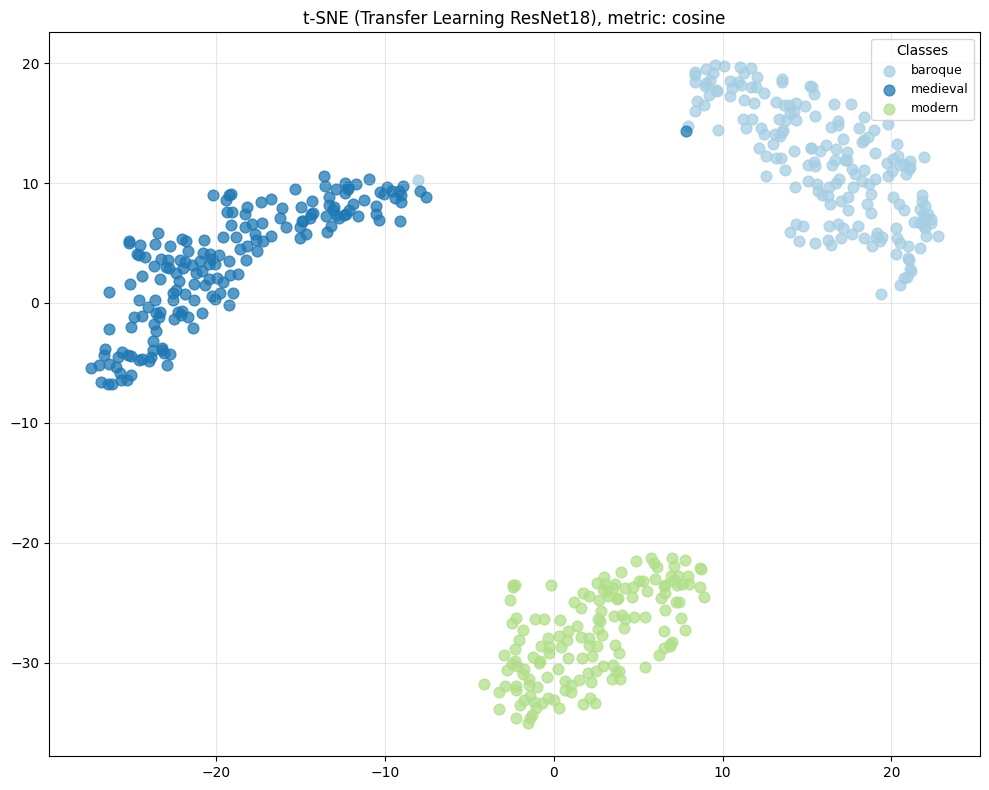

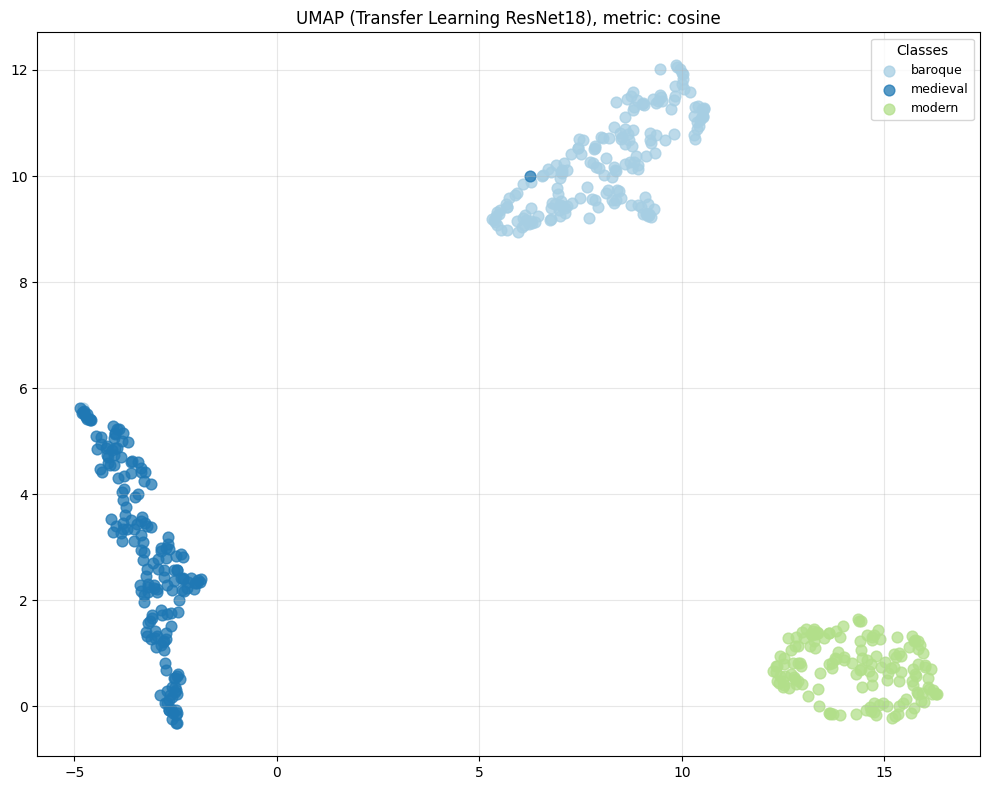

In [117]:
visualize_embeddings_tl(tl_model, test_loader, classes)